<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations_Regression_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [2]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [3]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./train_pm25.csv")

# Display the first 3 examples.
dataset_df.head(3)

,No,year,month,day,hour,pm25,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [4]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm25    41757 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.1+ MB


In [5]:
# Name of the label column.
label = "pm25"

# classes = dataset_df[label].unique().tolist()
# print(f"Label classes: {classes}")

# dataset_df[label] = dataset_df[label].map(classes.index)

In [6]:
print(f"Number of records in dataframe: {len(dataset_df)}")

Number of records in dataframe: 41757


## Helper Methods

In [7]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[35000:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [8]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30, task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [9]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30,
                                                   task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [10]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

## Train with Different Records

In [11]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [12]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [500, 1000, 2000, 4000, 8000, 16000, 32000, 35000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

500 examples in training, 6757 examples for testing.


2021-08-04 11:48:51.576101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-04 11:48:51.583165: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999995000 Hz


8/8 [==============================] - 5s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.988 min:-28 max:28 sd:14.8523
	1: "Ir" NUMERICAL mean:0.242 min:0 max:36 sd:2.00386
	2: "Is" NUMERICAL mean:0.02 min:0 max:9 sd:0.404475
	3: "Iws" NUMERICAL mean:24.3665 min:0.45 max:534.65 sd:54.9387
	4: "No" NUMERICAL mean:22043.2 min:209 max:43702 sd:12857.2
	5: "PRES" NUMERICAL mean:1016.84 min:995 max:1046 sd:10.2683
	6: "TEMP" NUMERICAL mean:12.56 min:-15 max:36 sd:12.5304
	8: "day" NUMERICAL mean:15.606 min:1 max:31 sd:8.8072
	9: "hour" NUMERICAL mean:11.09 min:0 max:23 sd:6.9695
	10: "month" NUMERICAL mean:6.3 min:1 max:12 sd:3.45398
	11: "year" NUMERICAL mean:2012.03 min:2010 ma

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 5840.0630
MSE: 5840.06298828125 in 7.999392747879028 secs
8/8 [==============================] - 0s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.988 min:-28 max:28 sd:14.8523
	1: "Ir" NUMERICAL mean:0.242 min:0 max:36 sd:2.00386
	2: "Is" NUMERICAL mean:0.02 min:0 max:9 sd:0.404475
	3: "Iws" NUMERICAL mean:24.3665 min:0.45 max:534.65 sd:54.9387
	4: "No" NUMERICAL mean:22043.2 min:209 max:43702 sd:12857.2
	5: "PRES" NUMERICAL mean:1016.84 min:995 max:1046 sd:10.2683
	6: "TEMP" NUMERICAL mean:12.56 min:-15 max:36 sd:12.5304
	8: "day" NUMERICAL mean:15.606 min:1 max:31 sd:8.8072
	9: "hour" NUMERICAL mean:11.09 min:0 max:23 sd:6.9695
	10: "month" NUMERICAL mean:6.3 min:1 max:12 sd:3.45398
	11: "year" NUMERICAL mean:2012.03 min:2010 ma

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 5791.9883
MSE: 5791.98828125 in 0.9521262645721436 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.988 min:-28 max:28 sd:14.8523
	1: "Ir" NUMERICAL mean:0.242 min:0 max:36 sd:2.00386
	2: "Is" NUMERICAL mean:0.02 min:0 max:9 sd:0.404475
	3: "Iws" NUMERICAL mean:24.3665 min:0.45 max:534.65 sd:54.9387
	4: "No" NUMERICAL mean:22043.2 min:209 max:43702 sd:12857.2
	5: "PRES" NUMERICAL mean:1016.84 min:995 max:1046 sd:10.2683
	6: "TEMP" NUMERICAL mean:12.56 min:-15 max:36 sd:12.5304
	8: "day" NUMERICAL mean:15.606 min:1 max:31 sd:8.8072
	9: "hour" NUMERICAL mean:11.09 min:0 max:23 sd:6.9695
	10: "month" NUMERICAL mean:6.3 min:1 max:12 sd:3.45398
	11: "year" NUMERICAL mean:2012.03 min:2010 ma

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8484.0537
MSE: 8484.0537109375 in 0.8598220348358154 secs
1000 examples in training, 6757 examples for testing.
16/16 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.699 min:-30 max:28 sd:14.7704
	1: "Ir" NUMERICAL mean:0.194 min:0 max:36 sd:1.57619
	2: "Is" NUMERICAL mean:0.049 min:0 max:10 sd:0.608768
	3: "Iws" NUMERICAL mean:26.1066 min:0.45 max:534.65 sd:56.4967
	4: "No" NUMERICAL mean:22314.4 min:72 max:43790 sd:12845.2
	5: "PRES" NUMERICAL mean:1016.53 min:994 max:1046 sd:10.1087
	6: "TEMP" NUMERICAL mean:12.469 min:-16 max:40 sd:12.4813
	8: "day" NUMERICAL mean:15.618 min:1 max:31 sd:8.76436
	9: "hour" NUMERICAL mean:11.242 min:0 max:23 sd:6.9911
	10: "month" NUMERICAL mean:6.442 min:1 max:12 sd:3.45755
	11: "year" NUMERICAL mean:2012.05 mi

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 5226.3745
MSE: 5226.37451171875 in 0.9940729141235352 secs
16/16 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.699 min:-30 max:28 sd:14.7704
	1: "Ir" NUMERICAL mean:0.194 min:0 max:36 sd:1.57619
	2: "Is" NUMERICAL mean:0.049 min:0 max:10 sd:0.608768
	3: "Iws" NUMERICAL mean:26.1066 min:0.45 max:534.65 sd:56.4967
	4: "No" NUMERICAL mean:22314.4 min:72 max:43790 sd:12845.2
	5: "PRES" NUMERICAL mean:1016.53 min:994 max:1046 sd:10.1087
	6: "TEMP" NUMERICAL mean:12.469 min:-16 max:40 sd:12.4813
	8: "day" NUMERICAL mean:15.618 min:1 max:31 sd:8.76436
	9: "hour" NUMERICAL mean:11.242 min:0 max:23 sd:6.9911
	10: "month" NUMERICAL mean:6.442 min:1 max:12 sd:3.45755
	11: "year" NUMERICAL mean:2012.05 mi

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 5375.8916
MSE: 5375.8916015625 in 0.9175870418548584 secs
16/16 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.699 min:-30 max:28 sd:14.7704
	1: "Ir" NUMERICAL mean:0.194 min:0 max:36 sd:1.57619
	2: "Is" NUMERICAL mean:0.049 min:0 max:10 sd:0.608768
	3: "Iws" NUMERICAL mean:26.1066 min:0.45 max:534.65 sd:56.4967
	4: "No" NUMERICAL mean:22314.4 min:72 max:43790 sd:12845.2
	5: "PRES" NUMERICAL mean:1016.53 min:994 max:1046 sd:10.1087
	6: "TEMP" NUMERICAL mean:12.469 min:-16 max:40 sd:12.4813
	8: "day" NUMERICAL mean:15.618 min:1 max:31 sd:8.76436
	9: "hour" NUMERICAL mean:11.242 min:0 max:23 sd:6.9911
	10: "month" NUMERICAL mean:6.442 min:1 max:12 sd:3.45755
	11: "year" NUMERICAL mean:2012.05 mi

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8480.9697
MSE: 8480.9697265625 in 0.9406614303588867 secs
2000 examples in training, 6757 examples for testing.
32/32 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.599 min:-35 max:28 sd:14.6758
	1: "Ir" NUMERICAL mean:0.198 min:0 max:36 sd:1.52013
	2: "Is" NUMERICAL mean:0.06 min:0 max:20 sd:0.80895
	3: "Iws" NUMERICAL mean:25.0122 min:0.45 max:534.65 sd:53.877
	4: "No" NUMERICAL mean:21927.2 min:50 max:43824 sd:12759.8
	5: "PRES" NUMERICAL mean:1016.64 min:994 max:1046 sd:10.2099
	6: "TEMP" NUMERICAL mean:12.289 min:-16 max:40 sd:12.4457
	8: "day" NUMERICAL mean:15.438 min:1 max:31 sd:8.735
	9: "hour" NUMERICAL mean:11.411 min:0 max:23 sd:6.93506
	10: "month" NUMERICAL mean:6.523 min:1 max:12 sd:3.49749
	11: "year" NUMERICAL mean:2012 min:2010 

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4386.4858
MSE: 4386.48583984375 in 1.4074134826660156 secs
32/32 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.599 min:-35 max:28 sd:14.6758
	1: "Ir" NUMERICAL mean:0.198 min:0 max:36 sd:1.52013
	2: "Is" NUMERICAL mean:0.06 min:0 max:20 sd:0.80895
	3: "Iws" NUMERICAL mean:25.0122 min:0.45 max:534.65 sd:53.877
	4: "No" NUMERICAL mean:21927.2 min:50 max:43824 sd:12759.8
	5: "PRES" NUMERICAL mean:1016.64 min:994 max:1046 sd:10.2099
	6: "TEMP" NUMERICAL mean:12.289 min:-16 max:40 sd:12.4457
	8: "day" NUMERICAL mean:15.438 min:1 max:31 sd:8.735
	9: "hour" NUMERICAL mean:11.411 min:0 max:23 sd:6.93506
	10: "month" NUMERICAL mean:6.523 min:1 max:12 sd:3.49749
	11: "year" NUMERICAL mean:2012 min:2010 

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4748.5918
MSE: 4748.591796875 in 0.95310378074646 secs
32/32 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.599 min:-35 max:28 sd:14.6758
	1: "Ir" NUMERICAL mean:0.198 min:0 max:36 sd:1.52013
	2: "Is" NUMERICAL mean:0.06 min:0 max:20 sd:0.80895
	3: "Iws" NUMERICAL mean:25.0122 min:0.45 max:534.65 sd:53.877
	4: "No" NUMERICAL mean:21927.2 min:50 max:43824 sd:12759.8
	5: "PRES" NUMERICAL mean:1016.64 min:994 max:1046 sd:10.2099
	6: "TEMP" NUMERICAL mean:12.289 min:-16 max:40 sd:12.4457
	8: "day" NUMERICAL mean:15.438 min:1 max:31 sd:8.735
	9: "hour" NUMERICAL mean:11.411 min:0 max:23 sd:6.93506
	10: "month" NUMERICAL mean:6.523 min:1 max:12 sd:3.49749
	11: "year" NUMERICAL mean:2012 min:2010 

106/106 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - mse: 8462.4434
MSE: 8462.443359375 in 1.1304080486297607 secs
4000 examples in training, 6757 examples for testing.
63/63 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.8245 min:-35 max:28 sd:14.5941
	1: "Ir" NUMERICAL mean:0.209 min:0 max:36 sd:1.54315
	2: "Is" NUMERICAL mean:0.0525 min:0 max:20 sd:0.742121
	3: "Iws" NUMERICAL mean:25.0316 min:0.45 max:565.49 sd:51.9732
	4: "No" NUMERICAL mean:21960.6 min:27 max:43824 sd:12641.4
	5: "PRES" NUMERICAL mean:1016.4 min:993 max:1046 sd:10.3149
	6: "TEMP" NUMERICAL mean:12.4685 min:-16 max:40 sd:12.2839
	8: "day" NUMERICAL mean:15.6118 min:1 max:31 sd:8.78533
	9: "hour" NUMERICAL mean:11.4708 min:0 max:23 sd:6.95939
	10: "month" NUMERICAL mean:6.50925 min:1 max:12 sd:3.46084
	11: "year" NUMERICAL mean:201

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 3801.6716
MSE: 3801.671630859375 in 1.3867828845977783 secs
63/63 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.8245 min:-35 max:28 sd:14.5941
	1: "Ir" NUMERICAL mean:0.209 min:0 max:36 sd:1.54315
	2: "Is" NUMERICAL mean:0.0525 min:0 max:20 sd:0.742121
	3: "Iws" NUMERICAL mean:25.0316 min:0.45 max:565.49 sd:51.9732
	4: "No" NUMERICAL mean:21960.6 min:27 max:43824 sd:12641.4
	5: "PRES" NUMERICAL mean:1016.4 min:993 max:1046 sd:10.3149
	6: "TEMP" NUMERICAL mean:12.4685 min:-16 max:40 sd:12.2839
	8: "day" NUMERICAL mean:15.6118 min:1 max:31 sd:8.78533
	9: "hour" NUMERICAL mean:11.4708 min:0 max:23 sd:6.95939
	10: "month" NUMERICAL mean:6.50925 min:1 max:12 sd:3.46084
	11: "year" NUMERICAL mean:201

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4516.6587
MSE: 4516.65869140625 in 1.3008549213409424 secs
63/63 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.8245 min:-35 max:28 sd:14.5941
	1: "Ir" NUMERICAL mean:0.209 min:0 max:36 sd:1.54315
	2: "Is" NUMERICAL mean:0.0525 min:0 max:20 sd:0.742121
	3: "Iws" NUMERICAL mean:25.0316 min:0.45 max:565.49 sd:51.9732
	4: "No" NUMERICAL mean:21960.6 min:27 max:43824 sd:12641.4
	5: "PRES" NUMERICAL mean:1016.4 min:993 max:1046 sd:10.3149
	6: "TEMP" NUMERICAL mean:12.4685 min:-16 max:40 sd:12.2839
	8: "day" NUMERICAL mean:15.6118 min:1 max:31 sd:8.78533
	9: "hour" NUMERICAL mean:11.4708 min:0 max:23 sd:6.95939
	10: "month" NUMERICAL mean:6.50925 min:1 max:12 sd:3.46084
	11: "year" NUMERICAL mean:201

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8466.5273
MSE: 8466.52734375 in 0.9744846820831299 secs
8000 examples in training, 6757 examples for testing.
125/125 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.85413 min:-40 max:28 sd:14.4973
	1: "Ir" NUMERICAL mean:0.20125 min:0 max:36 sd:1.43936
	2: "Is" NUMERICAL mean:0.0425 min:0 max:27 sd:0.704588
	3: "Iws" NUMERICAL mean:24.4804 min:0.45 max:565.49 sd:50.6781
	4: "No" NUMERICAL mean:22206.1 min:27 max:43824 sd:12579.2
	5: "PRES" NUMERICAL mean:1016.33 min:993 max:1046 sd:10.3318
	6: "TEMP" NUMERICAL mean:12.5388 min:-17 max:40 sd:12.1879
	8: "day" NUMERICAL mean:15.6036 min:1 max:31 sd:8.74057
	9: "hour" NUMERICAL mean:11.5441 min:0 max:23 sd:6.95554
	10: "month" NUMERICAL mean:6.55762 min:1 max:12 sd:3.44937
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 2988.3945
MSE: 2988.39453125 in 1.7536396980285645 secs
125/125 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.85413 min:-40 max:28 sd:14.4973
	1: "Ir" NUMERICAL mean:0.20125 min:0 max:36 sd:1.43936
	2: "Is" NUMERICAL mean:0.0425 min:0 max:27 sd:0.704588
	3: "Iws" NUMERICAL mean:24.4804 min:0.45 max:565.49 sd:50.6781
	4: "No" NUMERICAL mean:22206.1 min:27 max:43824 sd:12579.2
	5: "PRES" NUMERICAL mean:1016.33 min:993 max:1046 sd:10.3318
	6: "TEMP" NUMERICAL mean:12.5388 min:-17 max:40 sd:12.1879
	8: "day" NUMERICAL mean:15.6036 min:1 max:31 sd:8.74057
	9: "hour" NUMERICAL mean:11.5441 min:0 max:23 sd:6.95554
	10: "month" NUMERICAL mean:6.55762 min:1 max:12 sd:3.44937
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4323.3862
MSE: 4323.38623046875 in 1.9384191036224365 secs
125/125 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.85413 min:-40 max:28 sd:14.4973
	1: "Ir" NUMERICAL mean:0.20125 min:0 max:36 sd:1.43936
	2: "Is" NUMERICAL mean:0.0425 min:0 max:27 sd:0.704588
	3: "Iws" NUMERICAL mean:24.4804 min:0.45 max:565.49 sd:50.6781
	4: "No" NUMERICAL mean:22206.1 min:27 max:43824 sd:12579.2
	5: "PRES" NUMERICAL mean:1016.33 min:993 max:1046 sd:10.3318
	6: "TEMP" NUMERICAL mean:12.5388 min:-17 max:40 sd:12.1879
	8: "day" NUMERICAL mean:15.6036 min:1 max:31 sd:8.74057
	9: "hour" NUMERICAL mean:11.5441 min:0 max:23 sd:6.95554
	10: "month" NUMERICAL mean:6.55762 min:1 max:12 sd:3.44937
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8457.3535
MSE: 8457.353515625 in 1.1901724338531494 secs
16000 examples in training, 6757 examples for testing.
250/250 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.88888 min:-40 max:28 sd:14.4464
	1: "Ir" NUMERICAL mean:0.202 min:0 max:36 sd:1.4812
	2: "Is" NUMERICAL mean:0.0471875 min:0 max:27 sd:0.73635
	3: "Iws" NUMERICAL mean:24.1941 min:0.45 max:565.49 sd:50.3111
	4: "No" NUMERICAL mean:22259.8 min:27 max:43824 sd:12625.7
	5: "PRES" NUMERICAL mean:1016.37 min:991 max:1046 sd:10.308
	6: "TEMP" NUMERICAL mean:12.5246 min:-18 max:42 sd:12.1293
	8: "day" NUMERICAL mean:15.6809 min:1 max:31 sd:8.75683
	9: "hour" NUMERICAL mean:11.5253 min:0 max:23 sd:6.95009
	10: "month" NUMERICAL mean:6.52663 min:1 max:12 sd:3.43881
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 2342.1648
MSE: 2342.164794921875 in 2.6967854499816895 secs
250/250 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.88888 min:-40 max:28 sd:14.4464
	1: "Ir" NUMERICAL mean:0.202 min:0 max:36 sd:1.4812
	2: "Is" NUMERICAL mean:0.0471875 min:0 max:27 sd:0.73635
	3: "Iws" NUMERICAL mean:24.1941 min:0.45 max:565.49 sd:50.3111
	4: "No" NUMERICAL mean:22259.8 min:27 max:43824 sd:12625.7
	5: "PRES" NUMERICAL mean:1016.37 min:991 max:1046 sd:10.308
	6: "TEMP" NUMERICAL mean:12.5246 min:-18 max:42 sd:12.1293
	8: "day" NUMERICAL mean:15.6809 min:1 max:31 sd:8.75683
	9: "hour" NUMERICAL mean:11.5253 min:0 max:23 sd:6.95009
	10: "month" NUMERICAL mean:6.52663 min:1 max:12 sd:3.43881
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4272.7710
MSE: 4272.77099609375 in 2.0484020709991455 secs
250/250 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.88888 min:-40 max:28 sd:14.4464
	1: "Ir" NUMERICAL mean:0.202 min:0 max:36 sd:1.4812
	2: "Is" NUMERICAL mean:0.0471875 min:0 max:27 sd:0.73635
	3: "Iws" NUMERICAL mean:24.1941 min:0.45 max:565.49 sd:50.3111
	4: "No" NUMERICAL mean:22259.8 min:27 max:43824 sd:12625.7
	5: "PRES" NUMERICAL mean:1016.37 min:991 max:1046 sd:10.308
	6: "TEMP" NUMERICAL mean:12.5246 min:-18 max:42 sd:12.1293
	8: "day" NUMERICAL mean:15.6809 min:1 max:31 sd:8.75683
	9: "hour" NUMERICAL mean:11.5253 min:0 max:23 sd:6.95009
	10: "month" NUMERICAL mean:6.52663 min:1 max:12 sd:3.43881
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8456.3145
MSE: 8456.314453125 in 1.18556547164917 secs
32000 examples in training, 6757 examples for testing.
500/500 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.78025 min:-40 max:28 sd:14.446
	1: "Ir" NUMERICAL mean:0.202125 min:0 max:36 sd:1.45326
	2: "Is" NUMERICAL mean:0.05025 min:0 max:27 sd:0.739704
	3: "Iws" NUMERICAL mean:23.8113 min:0.45 max:565.49 sd:49.4023
	4: "No" NUMERICAL mean:22247.4 min:25 max:43824 sd:12651.5
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.2989
	6: "TEMP" NUMERICAL mean:12.4147 min:-19 max:42 sd:12.1711
	8: "day" NUMERICAL mean:15.6751 min:1 max:31 sd:8.78587
	9: "hour" NUMERICAL mean:11.5281 min:0 max:23 sd:6.92656
	10: "month" NUMERICAL mean:6.50237 min:1 max:12 sd:3.45274
	11: "year" NUMERICAL 

106/106 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 1681.2960
MSE: 1681.2960205078125 in 4.428371429443359 secs
500/500 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.78025 min:-40 max:28 sd:14.446
	1: "Ir" NUMERICAL mean:0.202125 min:0 max:36 sd:1.45326
	2: "Is" NUMERICAL mean:0.05025 min:0 max:27 sd:0.739704
	3: "Iws" NUMERICAL mean:23.8113 min:0.45 max:565.49 sd:49.4023
	4: "No" NUMERICAL mean:22247.4 min:25 max:43824 sd:12651.5
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.2989
	6: "TEMP" NUMERICAL mean:12.4147 min:-19 max:42 sd:12.1711
	8: "day" NUMERICAL mean:15.6751 min:1 max:31 sd:8.78587
	9: "hour" NUMERICAL mean:11.5281 min:0 max:23 sd:6.92656
	10: "month" NUMERICAL mean:6.50237 min:1 max:12 sd:3.45274
	11: "year" NUMERICAL 

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4377.2373
MSE: 4377.2373046875 in 3.3256397247314453 secs
500/500 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.78025 min:-40 max:28 sd:14.446
	1: "Ir" NUMERICAL mean:0.202125 min:0 max:36 sd:1.45326
	2: "Is" NUMERICAL mean:0.05025 min:0 max:27 sd:0.739704
	3: "Iws" NUMERICAL mean:23.8113 min:0.45 max:565.49 sd:49.4023
	4: "No" NUMERICAL mean:22247.4 min:25 max:43824 sd:12651.5
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.2989
	6: "TEMP" NUMERICAL mean:12.4147 min:-19 max:42 sd:12.1711
	8: "day" NUMERICAL mean:15.6751 min:1 max:31 sd:8.78587
	9: "hour" NUMERICAL mean:11.5281 min:0 max:23 sd:6.92656
	10: "month" NUMERICAL mean:6.50237 min:1 max:12 sd:3.45274
	11: "year" NUMERICAL 

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8455.9131
MSE: 8455.9130859375 in 1.9424653053283691 secs
35000 examples in training, 6757 examples for testing.
547/547 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.77457 min:-40 max:28 sd:14.4373
	1: "Ir" NUMERICAL mean:0.1982 min:0 max:36 sd:1.434
	2: "Is" NUMERICAL mean:0.0514571 min:0 max:27 sd:0.747727
	3: "Iws" NUMERICAL mean:23.7907 min:0.45 max:565.49 sd:49.2862
	4: "No" NUMERICAL mean:22259.3 min:25 max:43824 sd:12652
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.3013
	6: "TEMP" NUMERICAL mean:12.4079 min:-19 max:42 sd:12.1717
	8: "day" NUMERICAL mean:15.6719 min:1 max:31 sd:8.78641
	9: "hour" NUMERICAL mean:11.5096 min:0 max:23 sd:6.93077
	10: "month" NUMERICAL mean:6.50669 min:1 max:12 sd:3.45251
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 1531.5800
MSE: 1531.5799560546875 in 5.832144021987915 secs
547/547 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.77457 min:-40 max:28 sd:14.4373
	1: "Ir" NUMERICAL mean:0.1982 min:0 max:36 sd:1.434
	2: "Is" NUMERICAL mean:0.0514571 min:0 max:27 sd:0.747727
	3: "Iws" NUMERICAL mean:23.7907 min:0.45 max:565.49 sd:49.2862
	4: "No" NUMERICAL mean:22259.3 min:25 max:43824 sd:12652
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.3013
	6: "TEMP" NUMERICAL mean:12.4079 min:-19 max:42 sd:12.1717
	8: "day" NUMERICAL mean:15.6719 min:1 max:31 sd:8.78641
	9: "hour" NUMERICAL mean:11.5096 min:0 max:23 sd:6.93077
	10: "month" NUMERICAL mean:6.50669 min:1 max:12 sd:3.45251
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 4224.5747
MSE: 4224.57470703125 in 3.3395919799804688 secs
547/547 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 13

Number of columns by type:
	NUMERICAL: 12 (92.3077%)
	CATEGORICAL: 1 (7.69231%)

Columns:

NUMERICAL: 12 (92.3077%)
	0: "DEWP" NUMERICAL mean:1.77457 min:-40 max:28 sd:14.4373
	1: "Ir" NUMERICAL mean:0.1982 min:0 max:36 sd:1.434
	2: "Is" NUMERICAL mean:0.0514571 min:0 max:27 sd:0.747727
	3: "Iws" NUMERICAL mean:23.7907 min:0.45 max:565.49 sd:49.2862
	4: "No" NUMERICAL mean:22259.3 min:25 max:43824 sd:12652
	5: "PRES" NUMERICAL mean:1016.43 min:991 max:1046 sd:10.3013
	6: "TEMP" NUMERICAL mean:12.4079 min:-19 max:42 sd:12.1717
	8: "day" NUMERICAL mean:15.6719 min:1 max:31 sd:8.78641
	9: "hour" NUMERICAL mean:11.5096 min:0 max:23 sd:6.93077
	10: "month" NUMERICAL mean:6.50669 min:1 max:12 sd:3.45251
	11: "year" NUMERICAL mea

106/106 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 8455.9014
MSE: 8455.9013671875 in 2.360297679901123 secs


## Plotting Results

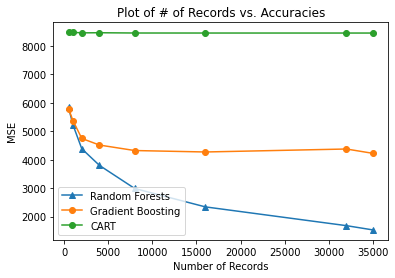

In [13]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("MSE")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

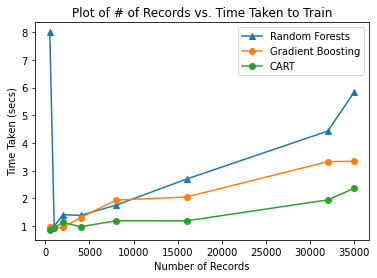

In [14]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[2] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()